# Please **DO NOT** run any cells as everything (all final images, graphs, etc. are preloaded)

# Section 0 Preface for Imports, Data Handling, & Methodologies 

## Section 0.1 Preface for Write-Up Interpretation & Acknowledgements

For the remainder of this notebook, each part 1) and 2) will be answered in line with notation for the following block of code to show:

1. A brief statement (~paragraph) of what was done to answer the question (narratively explaining what you did in code to answer the question, at a high level).

2. A brief statement (~paragraph) as to why this was done (why the question was answered in this way, not by doing something else. Some kind of rationale as to why you did x and not y or z to answer the question – why is what you did a suitable approach?).

For 3) and 4) (below) the findings and interpretations will be provided in Results & Discussions for each question (model(s)) we ran.

3. A brief statement (~paragraph) as to what was found. This should be as objective and specific as possible – just the results/facts. Do make sure to include numbers and a figure (=a graph or plot) in your statement, to substantiate and illustrate it, respectively. As the unsupervised methods often yield visualizable results, be sure to include a figure. 

4. A brief statement (~paragraph) as to what you think the findings mean. This is your interpretation of your findings and should answer the original question.

Code was used from my own Github repository, found at `www.github.com/sunnydigital/IDS_F21`, including code derived from Stephen Spivak from Introduction to Data Science, Fall 2021. Most of the code falling under the aforementioned two categories surrounds the `PCA` and `k-means` analysis plots.

All code used in this analysis attributable to Introduction to Machine Learning is not cited - we feel it is fair to use code from the course.

The author refers to all analysis performed in the first-person plural tense 'we,' as the author believes it to be weird to say *'I'* did anything, given all *I* did was learn from the amazing instructors & TAs :) Thank you.

## Section 0.2 Imports & Installation of Packages and Libraries, Seaborn Settings

Below we import packages & libraries as well as set the settings for `seaborn` plots

In [1]:
!pip install eli5
!pip install graphviz
!pip install scikit-optimize
!pip install tune_sklearn
!pip install scikit-plot
!pip install statsmodels

In [11]:
import os
import time
import re

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.activation import Softmax
import torch.optim as optim

from statsmodels.distributions.empirical_distribution import ECDF
# import statsmodels.api as sm

import scipy.stats as st
# import statsmodels.api as sm ## Need revision for Windows use
from scipy.stats import zscore
from scipy.spatial.distance import squareform

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn import tree, ensemble, metrics, calibration
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples

from IPython import display

from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import eli5

from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from skopt import BayesSearchCV

from tune_sklearn import TuneSearchCV, TuneGridSearchCV
import ray.tune as tune

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import scikitplot as skplt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")
import graphviz
import colorcet as cc

## Section 0.3

Checking the availability of CUDA for PyTorch on this Device and if available, use it for Adam Gradient Descent

In [3]:
'''print(f'CUDA is Available: {torch.cuda.is_available()}')
print(f'Current CUDA Device: {torch.cuda.current_device()}')
print(f'CUDA Device Location: {torch.cuda.device(0)}')
print(f'CUDA Device Count: {torch.cuda.device_count()}')
print(f'CUDA Device Name: {torch.cuda.get_device_name(0)}, {torch.cuda.get_device_name(1)}')'''

"print(f'CUDA is Available: {torch.cuda.is_available()}')\nprint(f'Current CUDA Device: {torch.cuda.current_device()}')\nprint(f'CUDA Device Location: {torch.cuda.device(0)}')\nprint(f'CUDA Device Count: {torch.cuda.device_count()}')\nprint(f'CUDA Device Name: {torch.cuda.get_device_name(0)}, {torch.cuda.get_device_name(1)}')"

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')
print(f'Currently Using Device: {device}')

Currently Using Device: cpu


## Section 0.4 Data Handling

Below, we check the presence of `NA`'s in the dataframe and afterwards, output a description of the dataframe, including `'all'` columns

In [12]:
df = pd.read_csv('wines.csv')

pd.set_option('display.max_columns', None)
print(f'Dataframe contains any NA values: {df.isnull().values.any()}')
df.describe(include='all')

Dataframe contains any NA values: False


,Alcohol,Malic_Acid,Ash,Ash_Alkalinity,Magnesium,Total_Phenols,Flavonoids,Stilbenes,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Viewing the entries of the first 10 rows of this new dataframe:

In [6]:
df.head(10)

,Alcohol,Malic_Acid,Ash,Ash_Alkalinity,Magnesium,Total_Phenols,Flavonoids,Stilbenes,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


## Section 0.5 Standardization & Normalization

For this dataset, (and the applicable functions of dimensionality reduction through PCA, t-SNE, MDS; and clustering through k-means and DBSCAN) I have chosen to standardize through the below mapping:

$$ \vec{X}_{Z} = \frac{\vec{X} - \mu_{\vec{X}}}{\sigma_{\vec{X}}} $$

where each $\vec{X}$ is a given column of data.

In [13]:
df_zscore = st.zscore(df)

We will now use `df_zscore` for every question moving forward, given the nature of all the aforementioned dimensionality reduction methods to depend on this standardization

### Correlation Matrix

Below, we view a correlation matrix of the data.

In [8]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(10)

/var/folders/dx/hz2jc9wd56zfh0zg63zt77_w0000gn/T/ipykernel_18233/3389594757.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(10)


,Alcohol,Malic_Acid,Ash,Ash_Alkalinity,Magnesium,Total_Phenols,Flavonoids,Stilbenes,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
Alcohol,1.0000000000,0.0943969409,0.2115445964,-0.3102351369,0.2707982259,0.2891011226,0.2368149279,-0.1559294667,0.1366979118,0.5463641951,-0.0717471973,0.0723431874,0.6437200372
Malic_Acid,0.0943969409,1.0000000000,0.1640454698,0.2885004028,-0.0545750961,-0.3351669972,-0.4110065876,0.2929771335,-0.2207461868,0.2489853441,-0.5612956887,-0.3687104283,-0.1920105646
Ash,0.2115445964,0.1640454698,1.0000000000,0.4433671866,0.2865866913,0.1289795377,0.1150772790,0.1862304463,0.0096519352,0.2588872593,-0.0746668890,0.0039112306,0.2236262637
Ash_Alkalinity,-0.3102351369,0.2885004028,0.4433671866,1.0000000000,-0.0833330886,-0.3211133173,-0.3513698601,0.3619217186,-0.1973268357,0.0187319809,-0.2739552227,-0.2767685489,-0.4405969313
Magnesium,0.2707982259,-0.0545750961,0.2865866913,-0.0833330886,1.0000000000,0.2144012347,0.1957837699,-0.2562940489,0.2364406098,0.1999500063,0.0553981956,0.0660039360,0.3933508494
Total_Phenols,0.2891011226,-0.3351669972,0.1289795377,-0.3211133173,0.2144012347,1.0000000000,0.8645635001,-0.4499353009,0.6124130838,-0.0551364177,0.4336813352,0.6999493648,0.4981148796
Flavonoids,0.2368149279,-0.4110065876,0.1150772790,-0.3513698601,0.1957837699,0.8645635001,1.0000000000,-0.5378996119,0.6526917686,-0.1723793983,0.5434785665,0.7871939019,0.4941931272
Stilbenes,-0.1559294667,0.2929771335,0.1862304463,0.3619217186,-0.2562940489,-0.4499353009,-0.5378996119,1.0000000000,-0.3658450990,0.1390570129,-0.2626396311,-0.5032695961,-0.3113851883
Proanthocyanins,0.1366979118,-0.2207461868,0.0096519352,-0.1973268357,0.2364406098,0.6124130838,0.6526917686,-0.3658450990,1.0000000000,-0.0252499308,0.2955442528,0.5190670957,0.3304167004
Color_Intensity,0.5463641951,0.2489853441,0.2588872593,0.0187319809,0.1999500063,-0.0551364177,-0.1723793983,0.1390570129,-0.0252499308,1.0000000000,-0.5218131932,-0.4288149418,0.3161001127


# Question 1

Do a PCA on the data. How many Eigenvalues are above 1? Plotting the 2D solution (projecting the data on the first 2 principal components), how much of the variance is explained by these two dimensions, and how would you interpret them?

## Section 1.0

We run a Principal Component Analysis using the `PCA` package from the `sklearn` library. When, we determine the `eig_vals` as the amount of explained variance, the `loadings` as the components of the output and `rotated_data` as the transformed data. Note the `* -1` for all lines of code: this was done due to a fundamental mistake in Python and makes outputs more interpretable. We then cycle through `eig_vals` to determine the percent of variance explained by each principal component.

This was done to initialize the PCA (with correct assumptions inclusive of Python flaws) and display the amount of variation attributable.

In [14]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])

pca = PCA().fit(df_zscore)

eig_vals = pca.explained_variance_
loadings = pca.components_ * -1
rotated_data = pca.fit_transform(df_zscore) * -1

covar_explained = eig_vals / sum(eig_vals) * 100

for n in range(len(covar_explained)):
    explained = covar_explained[n].round(5)
    print(f'{ordinal(n+1)} PC explains {explained}% of variance')

1st PC explains 36.19885% of variance
2nd PC explains 19.20749% of variance
3rd PC explains 11.12363% of variance
4th PC explains 7.06903% of variance
5th PC explains 6.56329% of variance
6th PC explains 4.93582% of variance
7th PC explains 4.23868% of variance
8th PC explains 2.68075% of variance
9th PC explains 2.22215% of variance
10th PC explains 1.93002% of variance
11th PC explains 1.73684% of variance
12th PC explains 1.29823% of variance
13th PC explains 0.79521% of variance


## Section 1.1 Scree Plot

Below we show a scree plot of the eigenvalues and the amount of total explainability (out of the total number of `eig_vals`) attributed to each PC. We then draw a line at `Eigenvalue = 1` to show how many `eig_vals` are above 1.

This was done to visually inspect the scree plot and determine the cutoff point for the Kaiser criterion (`Eigenvalue = 1`).

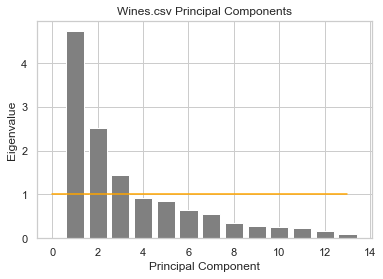

In [22]:
num_col = len(df_zscore.columns)
x = np.linspace(1,num_col, num_col)
plt.bar(x, eig_vals, color='gray')
plt.plot([0,num_col], [1,1], color='orange')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Wines.csv Principal Components')
plt.show()

## Section 1.2 Kaiser, Elbow, 90% Variance

Below we show code regarding the number of PCs to choose around each criterion. 

  * For the Kaiser criterion, we count the number of PCs with `eigenvalue > 1`
  * For the Elbow criterion I eyeballed the data and determined the cutoff point at 3 PCs
  * For the number of factors to account for more than 90% variance of the data, we ran `np.cumsum` on the `covar_explained` (as defined in Section 1.0) and count the number needed.

We do so due to these being the main methods of determining the number of PCs to choose, and run three methods to exhaustively optimize for the number.

Code from Introduction to Data Science, Fall 2021

In [16]:
threshold = 1

print('Number of factors selected by Kaiser criterion:', np.count_nonzero(eig_vals > threshold))

print('Number of factors selected by Elbow criterion: 3')

threshold = 90
eig_sum = np.cumsum(covar_explained)
print('Number of factors to account for at least 90% variance:', np.count_nonzero(eig_sum < threshold) + 1)

Number of factors selected by Kaiser criterion: 3
Number of factors selected by Elbow criterion: 3
Number of factors to account for at least 90% variance: 8


## Section 1.3 Principal Component Loadings Plots

Below (two cells) we cycle through the first 9 PCs and plot each attributable loadings using `seaborn`. Next, we output each predictor and the associated label.

This was done to provide an initial visual inspection of the loadings plots of each PC.

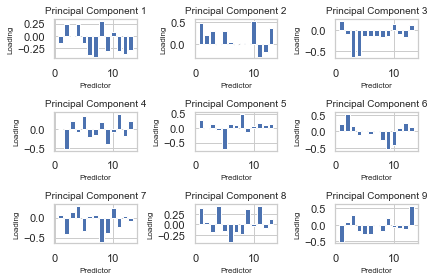

In [23]:
look_at = 9
for i in range(0,look_at):
    
    plt.subplot(3,3,i+1)
    plt.bar(x, loadings[i,:])
    
    plt.title(f'Principal Component {i+1}', fontsize=10)
    plt.xlabel('Predictor', fontsize=8)
    plt.ylabel('Loading', fontsize=8)
    
    plt.tight_layout()

In [24]:
for index in range(len(df_zscore.columns)):
    print(f'Predictor {index+1}: {df_zscore.columns[index]}')

Predictor 1: Alcohol
Predictor 2: Malic_Acid
Predictor 3: Ash
Predictor 4: Ash_Alkalinity
Predictor 5: Magnesium
Predictor 6: Total_Phenols
Predictor 7: Flavonoids
Predictor 8: Stilbenes
Predictor 9: Proanthocyanins
Predictor 10: Color_Intensity
Predictor 11: Hue
Predictor 12: OD280
Predictor 13: Proline


## Section 1.4 Scatterplot

As per requirements, we scatter a 2d plot of the first 2 PCs against each other, with PC1 on the x-axis and PC2 on the y-axis.

This was done as per requirements, but provides an ultimate visual representation of the associated PC loadings for later visual/clustering analysis.

Code modified from Introduction to Data Science Fall 2021

Text(0, 0.5, 'Principal Component 2')

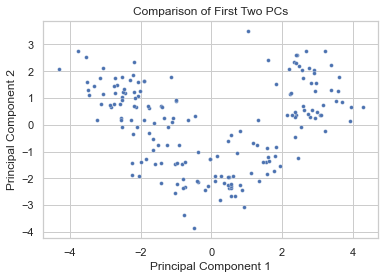

In [25]:
sns.scatterplot(x=rotated_data[:,0], y=rotated_data[:,1], s=15, marker='o')

plt.title('Comparison of First Two PCs')
# Set x-axis label
plt.xlabel('Principal Component 1')
# Set y-axis label
plt.ylabel('Principal Component 2')

## Section 1.5 J.F.S.&G.

Just for shits & giggles because, why not: 

We plot in 3d projections using `seaborn`'s `Axes3D` package the first 3 PCs. This was done to obtain a better understanding of the data. We see that PC3 provides only added variance, with a distribution horizontally around equal above and below the mean. Please disregard this as part of this assignment.

<IPython.core.display.Javascript object>


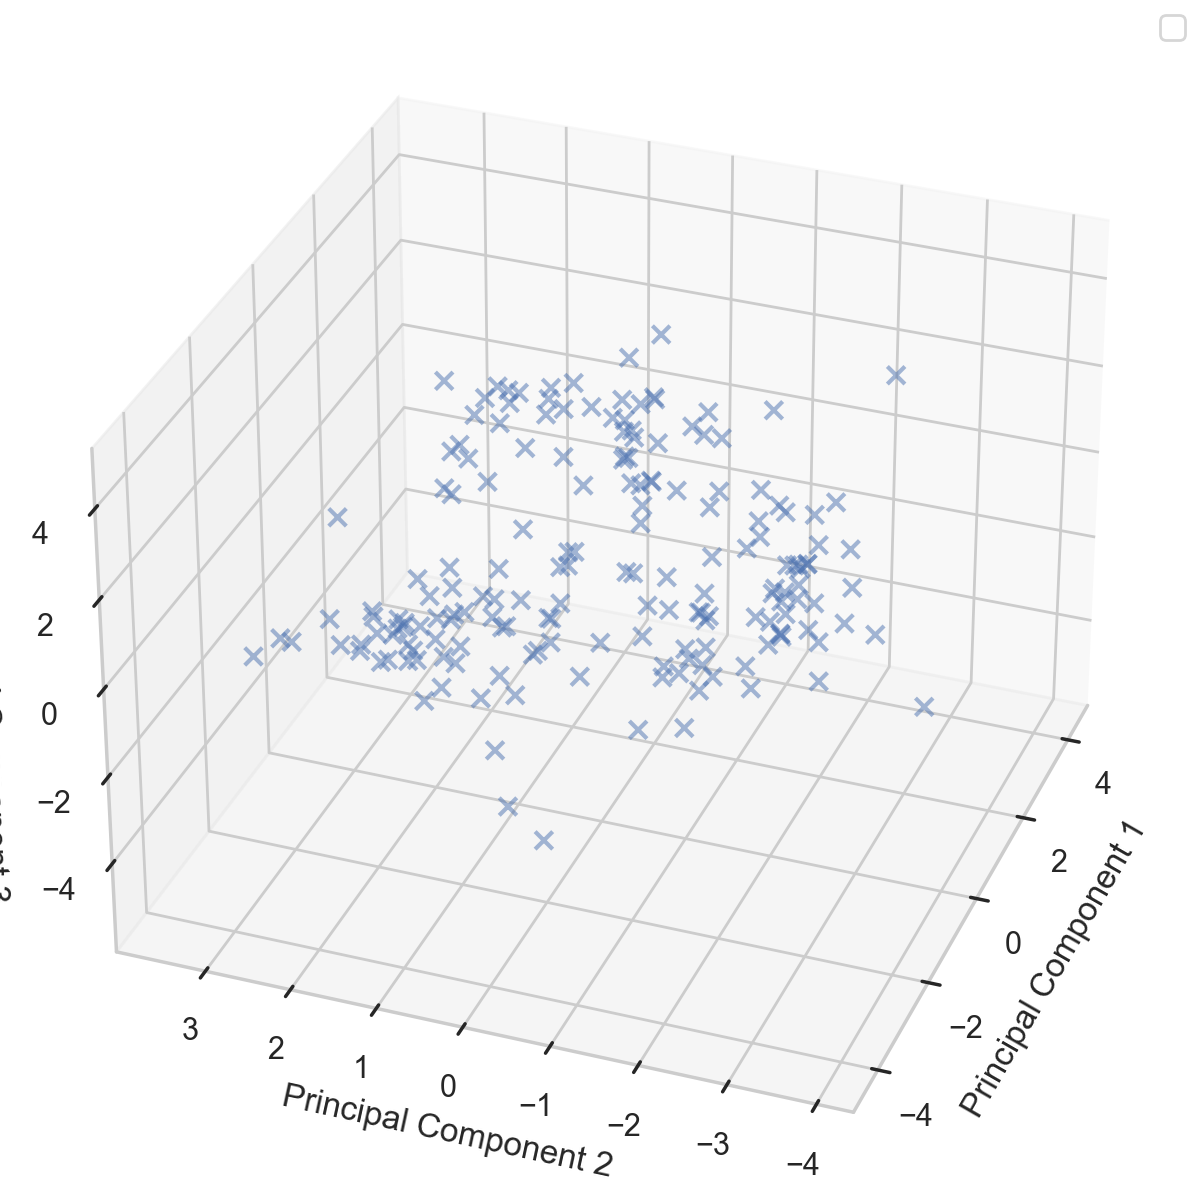

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Principal Component 3')

In [20]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sc = ax.scatter(rotated_data[:,0],
                rotated_data[:,1],
                rotated_data[:,2],
                s=40, marker='x', alpha=0.5)

ax.legend(loc='best')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

In [21]:
%matplotlib inline

## Section 1.6 Results & Discussion

From the Section 3.1 scree plot, we see that 3 PCs have `eigenvalue > 1`(adhering to the Kaiser criterion). This means that the number of PCs that have greater explanability of the total dataset greater than an individual feature is 3.

From the Section 1.0 original fitting and `cumsum` of `eig_vals` analysis, we see that the first PC accounts for "36.19885% of variance" and the second PC accounts for "19.20749% of variance". Together, they account for 45.40634% of the variance in the data. This means that with just 2 PCs, almost **half** of the variance in the data is accounted for, and in 2d this would be a well-suited method for visual/future-clustering analysis.

From viewing the `loadings` of the first two PCs, we see that:

   * PC1: loadings points positively towards `Malic_Acid`, `Ash_Alkalinity`, and `Stilbenes` but very negatively towards `Totel_Phenols`, `Flavonoids`, `Proanthocyanins`, `Hue`, `OD280`, and `Proline`. Unlisted loadings were near zero in magnitude.
   
   
   * PC2: positively towards `Alcohol`, `Malic_Acid`, `Ash`, `Magnesium`, strongly towards `Color_Intensity`, and `Proline` but negatively towards `Hue` and `OD280`. Unlisted loadings were near zero in magnitude.
   
In interpretation, we see that PC1 is accute towards features able to be interpreted as having high impact on smell (with `Malic_Acid`, `Ash_Alkalinity`, and `Stilbenes` all influencing the quality), and PC2 as being accute in features positioned toward taste (`Alcohol`, `Malic_Acid`, `Ash`, `Magnesium`, and `Proline`). It must be noted that for PC2, `Color_Intensity` is large in magnitude, but as the saying goes, the stronger the taste.[<sup>[2]</sup>](#fn2)[<sup>[3]</sup>](#fn3)

# Question 2

Use t-SNE on the data. How does KL-divergence depend on Perplexity (vary Perplexity from 5 to 150)? Make sure to plot this relationship. Also, show a plot of the 2D component with a Perplexity of 20. 

## Section 2.0 `TSNE` Fitting

We create a dictionary to store all the models we will run, with the associated perplexity tested as `key`, `value` pairs associated with an f string: `key` = `f'TSNE_perp_{perp}'` and the `value` = `tsne.fit_transform(df_zscore)`.

This was done to create iterables of the perplexity value (number of nearest neighbors to use in manifold learning)[<sup>[5]</sup>](#fn5) and associated model, for which we will call later on to determine the KL-divergence. It is roundabout, but provides for later testing (a `dict` object of the fit model will be able to fully render the model).

In [5]:
TSNE_dict = {}
for perp in range(5, 151):
    tsne = TSNE(n_components=2, perplexity=perp, verbose=1)
    tsne.fit_transform(df_zscore)
    TSNE_dict[f'TSNE_perp_{perp}'] = tsne

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.004s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 0.885539
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.755386
[t-SNE] KL divergence after 1000 iterations: 0.661848
[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 0.946090
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.016251


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.633491
[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 0.996417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.748932


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.599241
[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.040156
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.326614


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.613424
[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.079366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.115395


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.633243
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.115416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.964752


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.566914
[t-SNE] Computing 34 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.148987
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.738060


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.587599
[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.180573
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.840050


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.562242
[t-SNE] Computing 40 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.210666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.508049


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.553570
[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.239511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.901382


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.539537
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.267333
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.440964


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.522408
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.294263
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.989956


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.532828
[t-SNE] Computing 52 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.320500
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.242184


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.524869
[t-SNE] Computing 55 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.346151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.055386


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.493655
[t-SNE] Computing 58 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.371259
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.584488


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.516194
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.395894
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.764561


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.460038
[t-SNE] Computing 64 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.420125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.113346


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.464972
[t-SNE] Computing 67 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.443998
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.906769


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.449515
[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.467548
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.091339


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.443888
[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.490807
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.958122


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.425613
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.513801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.555035


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.409860
[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.536561
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.575581


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.413423
[t-SNE] Computing 82 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.559113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.275200


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.387401
[t-SNE] Computing 85 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.581478
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.225262


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.417843
[t-SNE] Computing 88 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.603679
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.247898


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.379296
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.625735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.340092


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.390386
[t-SNE] Computing 94 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.647647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.066334


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.380992
[t-SNE] Computing 97 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.669424
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.894325


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.378564
[t-SNE] Computing 100 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.691067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.324940


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.379278
[t-SNE] Computing 103 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.712584
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.612957


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.356456
[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.733980
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.481220


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.334705
[t-SNE] Computing 109 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.755256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.660305


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.323988
[t-SNE] Computing 112 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.776416
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.146702


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.342105
[t-SNE] Computing 115 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.797454
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.371082


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.304105
[t-SNE] Computing 118 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.818366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.438705


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.306586
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.839161
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.598820


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.307947
[t-SNE] Computing 124 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.859821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.032806


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.299297
[t-SNE] Computing 127 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.880336
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.768555


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.301115
[t-SNE] Computing 130 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.900709
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.546856


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.285956
[t-SNE] Computing 133 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.920934
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.823864


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.281633
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.941001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.171391


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.260107
[t-SNE] Computing 139 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.960913
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.391926


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.263415
[t-SNE] Computing 142 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.980667
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.895950


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.263255
[t-SNE] Computing 145 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.000256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.069794


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.256384
[t-SNE] Computing 148 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.019676
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.790115


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.249836
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.038932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.821022


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.240534
[t-SNE] Computing 154 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.058028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.652573


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.247549
[t-SNE] Computing 157 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.076968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.242592


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.228700
[t-SNE] Computing 160 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.095762


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.569546
[t-SNE] KL divergence after 1000 iterations: 0.228041
[t-SNE] Computing 163 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.114415
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.013664


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.217398
[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.132945
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.697418


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.211454
[t-SNE] Computing 169 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.151372
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.010864


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.225062
[t-SNE] Computing 172 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.169721


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.728531
[t-SNE] KL divergence after 750 iterations: 0.221183
[t-SNE] Computing 175 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.188008


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.893429
[t-SNE] KL divergence after 750 iterations: 0.218324
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.206250
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.967503


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.191304
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.224408


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.743496
[t-SNE] KL divergence after 950 iterations: 0.193595
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.242461
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.928356


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.205646
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.260418
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.885963


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.181666
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.278288


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.821968
[t-SNE] KL divergence after 1000 iterations: 0.194278
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.296076
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.593613


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.188511
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.313789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.620213


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.177707
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.331436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.081909


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.184344
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.349023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.621696


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.179649
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.366557
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.639603


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.171168
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.384045
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.782124


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.180758
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.401493
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.663757


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.165138
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.418907
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.344711


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.162743
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.436295
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.788460


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.157999
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.453661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.716972


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.146169
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.471014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.127575


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.149386
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.488358
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.136589


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.153554
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.505697
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.774529


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.163881
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.523041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.656452


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.132276
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.540394
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.665821


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.133658
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.557760
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.001629


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.137264
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.575147
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.818916


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.138561
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.592560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.429272


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.133721
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.610003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.956089


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.126571
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.627484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.084167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.118756
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.645006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.556744


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.130746
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.662578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.146362


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.123465
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.680200
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.577957


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.120703
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.697882
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.347515


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.110970
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.715630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.548988


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.115097
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.733445
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.714573


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.109447
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.751339
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.974789


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.116005
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.769312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.221184


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.114108
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.787372
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.121452


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.108682
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.805527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.749825


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.110986
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.823780
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.420685


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.098477
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.842139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.647835


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.099362
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.860608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.188137


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.101218
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.879195


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.826416
[t-SNE] KL divergence after 950 iterations: 0.093658
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.897908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.909443


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.103637
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.916750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.873299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.097861
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.935731
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.131748


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.093613
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.954857
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.116005


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.086166
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.974135
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.665085


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.090226
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 2.993572
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.184116


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.087989
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.013178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.611256


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.090319
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.032959
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.313293


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.083942
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.052920
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.291092


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.093251
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.073078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.444733


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.081143
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.093433
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.613167


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.079095
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.113998
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.760021


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.078933
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.134782
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.779724


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.074535
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.155796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.088474


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.074497
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.177051
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.530617


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.071330
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.198558
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.782539


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.067806
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.220323
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.152752


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.069690
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.242363
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.578613


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.071173
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.264687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.493916


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.067736
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.287310
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.720524


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.069392
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.310246
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.912682


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.066504
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.333511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.173855


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.065114
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.357115
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.077484


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.060022
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.381075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.103153


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.063379
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.405412
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.285328


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.055373
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.430139
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.083549


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.057985
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.455275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.671688


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.054305
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.480839
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.151955


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.053650
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.506855
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.389595


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.052896
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.533346
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.677731


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.051187
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.560327
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.031113


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.048954
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.587835
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.057125


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.049205
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.615886
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.442245


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.045242
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.644513
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.321976


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.049888
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.673750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.814716


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.045153
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.703620
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.732807


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.043828
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.734170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.707905


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.046060
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.765429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.977222


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.039408
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.797438
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.303299


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.040888
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.830242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.731045


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.037758
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.863891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.576897


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 950 iterations: 0.037962
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.898431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.746639


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 800 iterations: 0.036903
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.933920
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.156940


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.035598
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 3.970416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.993294
[t-SNE] KL divergence after 1000 iterations: 0.033957
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.007991
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.634476


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.035603
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.046714
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.125412


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.031079
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.086661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.993778


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.030683
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.127916
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.569622


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.028872
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.170573
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.170467


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 650 iterations: 0.028724
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.214753
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.802437


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 700 iterations: 0.028951
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.260557
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.848030


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 750 iterations: 0.027674
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.308124
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.402065


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 900 iterations: 0.025349
[t-SNE] Computing 177 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 4.357598
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.146812


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 850 iterations: 0.025080


## Section 2.1 KL-Divergence Calculation

we create a list (later turned `np.array` object) of index `None` being the perplexity value (obtained through `re` search of the `key`, the name of the dict), and index 1 being the associated KL-divergence (calculated through the attribute `value.kl_divergence_`, where `value` is the model associated with the `key` perplexity.

We do this to obtain associated perplexity, KL-divergence scores.

In [6]:
perp_KL = []
for key, value in TSNE_dict.items():
    perp_num = int(re.search('(?<=_perp_)\d+', key)[0])
    KL = value.kl_divergence_
    tmp = [perp_num, KL]
    
    perp_KL.append(tmp)

perp_KL = np.array(perp_KL)

## Section 2.2 Perplexity vs. KL-Divergence Plot

Below we plot the perplexity value and its associated KL-divergence.

This was done as per the requirements, but also as a way to visually inspect the data.

Text(0, 0.5, 'KL-Divergence')

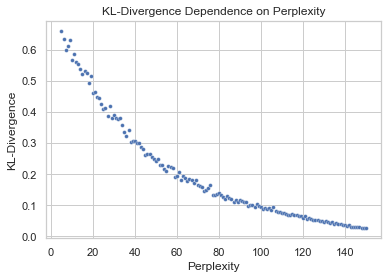

In [7]:
sns.scatterplot(x=perp_KL[:,0], y=perp_KL[:,1], s=15)

plt.title('KL-Divergence Dependence on Perplexity')
# Set x-axis label
plt.xlabel('Perplexity')
# Set y-axis label
plt.ylabel('KL-Divergence')

## Section 2.3 Specific Perplexity Plot

Below we plot the 2d components of the created model with `perplexity=20`.

This was done as per the requirements, but also as a way of visualizing the the outputs of the first 2 components/embeddings (component/embedding 1 vs. component/embedding 2) against one another to show potential relationship.

Text(0, 0.5, 't-SNE Component 2')

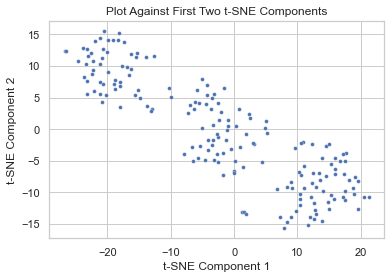

In [8]:
model = TSNE_dict['TSNE_perp_20']
embeddings = model.embedding_

sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], s=15)

plt.title('Plot Against First Two t-SNE Components')
# Set x-axis label
plt.xlabel('t-SNE Component 1')
# Set y-axis label
plt.ylabel('t-SNE Component 2')

## Section 2.4 Results & Discussion

As per Section 2.2, we see that there is a negative, convex relationship between perplexity and KL-divergence. This makes sense as perplexity can be interpreted as "the number of nearest neighbors that is used in... manifold learning," so increasing the perplexity will increaase the amount of non-local information retained in the dimensionality reduction. Thus, "accounting for greater variation in the dataset, producing less Shannon entropy (KL-divergence), using the equation shown below:"[<sup>[6]<sup>](#fn6) 
    
$$ D_{KL} = \sum_{i,j}\log \frac{p_{ij}}{q_{ij}} $$
    
where
    
$$ p_{ij} = \frac{\exp\left(-\frac{||\mathbf{x}_{i} - \mathbf{x}_{j}||}{2\sigma^{2}_{i}}\right)^{2}}{\sum_{k \neq i}\exp\left(-\frac{||\mathbf{x}_{i} - \mathbf{x}_{k}||}{2\sigma^{2}_{i}}\right)^{2}}$$

or the high dimensional affinity between any two points $ \mathbf{x}_{i} $ and $ \mathbf{x}_{j} $ and
    
$$ q_{ij} = \frac{\exp\left(-||\mathbf{y}_{i} - \mathbf{y}_{j}||\right)^{2}}{\sum_{k \neq i}\exp\left(-||\mathbf{y}_{i} - \mathbf{y}_{k}||\right)^{2}} $$

being the low dimensional affinity between any two points $ \mathbf{y}_{i} $ and $ \mathbf{y}_{j} $.
    
However, the decrease in entropy attenuates so marginally, that is: 
    
$$ \frac{d}{dP} D_{KL} < 0 $$
    
but
    
$$ \frac{d^{2}}{dP^{2}} D_{KL} > 0 $$
    
As per Section 2.3, we see that the first two t-SNE components (at `perplexity=20`) yields a plot of around linearly increasing (little convexity) plot of an eyeballed 3 potential clusters. This could signal the potential for 3 clusters, but will need to be confirmed using a non-distance/density based clustering algorithm.

# Question 3

Use MDS on the data. Try a 2-dimensional embedding. What is the resulting stress of this embedding? Also, plot this solution and comment on how it compares to t-SNE.  

## Section 3.0 `MDS` Initialization & Stress

Below we initialize a `MDS` class from `sklearn.manifold` with the required `n_components=2`. We default to `dissimilarity=euclidean`, finding the square root of the pairwise distances between points divided by the sum of squared distances of the higher dimensional points as the meter for dissimalirity (the resulting distances between points in the embedding). This dissimilarity (and associated loss function) is shown by the equation:

$$ \textrm{stress} = \sqrt{\frac{\sum_{i<j} (d_{ij} - \hat{d}_{ij})^{2}}{\sum d^{2}_{ij}}}$$

where $d_{ij}$ is the distance between two datapoints in the higher-dimensional space and $\hat{d}_{ij}$ is the distance between any two datapoints in the lower-dimensional space.

Note: the `sklearn.manifold.MDS` package incorporates the native loss function:

$$ \textrm{stress}_{SK-L} = \sum_{i<j} d_{ij} - \hat{d}_{ij} $$

so we divide by $ \sum d^{2}_{ij} $.

We then attempt permutation performance analysis, generating `num_val=5` replicates (due to random MDS initialization) for later analysis.

In [4]:
k_val = 5

cross = []
for i in range(k_val):
    mds = MDS(n_components=2, n_init=100, max_iter=10000) ## Initialized randomly, and requires 'euclidean'
    embeddings = mds.fit_transform(df_zscore)
    
    ssd = np.sum(mds.dissimilarity_matrix_ ** 2)
    stress = np.sqrt(mds.stress_/ssd)
    
    cross.append(stress)

## Section 3.1 Stress Permutation Validation

Below we determine the `maximum`, `minimum`, and `median` of the dataset, to calculate the range of variance for our n-fold validation (in our case, `n=5` from the above block). We then take the difference between the `maximum` and the `median` to calculate `upper_range` and `median` minus `minimum` to calculate `lower_range`. We then take the largest of the two to set our `abs_range`. This is the potential maximum variation in permutation of the loss function `stress` from our 5-fold analysis.

In [13]:
cross = np.array(cross)

maximum, minimum, median = np.max(cross), np.min(cross), np.median(cross)

upper_range = maximum - median
lower_range = median - minimum

abs_range = np.max([upper_range, lower_range])

print(f'Stress: {median:.5f} ± {abs_range:.5f}')

Stress: 0.15972 ± 0.00097


## Section 3.2 MDS Component Plots

Below we plot the MDS created with `components=2` and fit over the z-scored data using `matplotlib`, comparing MDS Component 1 on the x-axis to MDS Component 2 on the y-axis.

This was done to show the transformed data visually, as well as to fulfill requirements set out by the spec sheet.

Text(0, 0.5, 'MDS Axis 2')

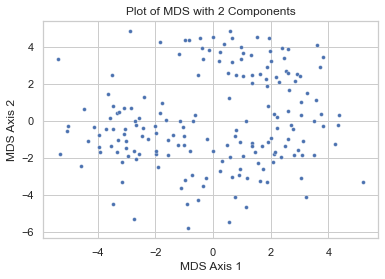

In [14]:
embeddings = mds.embedding_

sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], s=15)

plt.title('Plot of MDS with 2 Components')
# Set x-axis label
plt.xlabel('MDS Axis 1')
# Set y-axis label
plt.ylabel('MDS Axis 2')

## Section 3.3 Results & Discussion

From the above analysis, we see that the stress score (loss function for MDS) is: 21048.317 ± 167.085.
This would mean that the sum of squared distance differences between the higher-dimensional, untransformed data and the lower-dimensional, transformed data is 21048.317 ± 167.085.

Compared to the t-SNE plot (Section 2), we see less potential clustering between the x-axis and y-axis, with a more blobby overall distribution of points across the two dimensions (as opposed to the linearly increasing plot of the t-SNE with 3 distinct blobs).

# Question 4

Building on one of the dimensionality reduction methods above that yielded a 2D solution (1-3, your choice), use the Silhouette method to determine the optimal number of clusters and then use kMeans with that number (k) to produce a plot that represents each wine as a dot in a 2D space in the color of its cluster. What is the total sum of the distance of all points to their respective clusters centers, of this solution?

## Section 4.0

For this Section, we realized the importance of using a distance-preserving method of dimensionality reduction, given k-means' dependance on distance metrics to create clusters. This is why I chose PCA as the form of dimensionality reduction to be used, as opposed to t-SNE, which only preserves *local* similarities. I did not choose MDS nor t-SNE due to the lack of open interpretability of factors in both (loadings).

In the two blocks of code below, we call and create a `np.array` of the first two PCs of the PCA analysis done in Section 1. We then create a `np.array` of `NaN`s of `num_clusters` to look at, with `num_clusters=9` to store each sum of silhouette scores for every number of clusters tried.

We then loop through the 9 total clusters, using the `KMeans` class from `sklearn.cluster` to calculate the clusters for each number of clusters, and create subplots using `matplotlib` of associated silhouette score (found using `silhouette_samples` from `sklearn.metrics`) vs. count of occurrence. Each plot displays the number of clusters and the sum of the silhouette scores as the title.

This was done to output subplots showing the silhouette score vs. the count of occurrence, with titles bearing the sum of silhouette scores.

The code below is modified from Introduction to Data Science, Fall 2021

In [11]:
x = np.column_stack((rotated_data[:,0],rotated_data[:,1]))

num_clusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([num_clusters,1])*np.NaN # init container to store sums

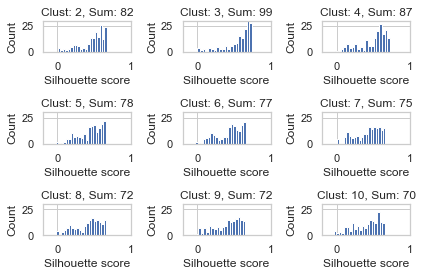

In [12]:
# Compute kMeans:
for i in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(i)).fit(x) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(x,cId) # compute the mean silhouette coefficient of all samples
    Q[i-2] = sum(s) # take the sum
    # Plot data:
    plt.subplot(3,3,i-1)
    plt.hist(s,bins=20) 
    plt.xlim(-0.2,1)
    plt.ylim(0,30)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title(f'Clust: {i}, Sum: {int(Q[i-2])}') # sum rounded to nearest integer
    plt.tight_layout() # adjusts subplot padding

## Section 4.1 Plot of Number of Clusters vs. Sum of Silhouette

Below we show on the x-axis the number of clusters vs. the sum of silhouette scores on the y-axis. We use `matplotlib` to plot the associated `np.linspace` object, set between 2 to 10 with 9 in-between divisions against the sum of silhouette scores obtained from the filled `Q` array in the previous section.

The code below is modified from Introduction to Data Science, Fall 2021 

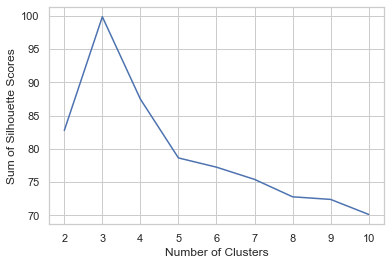

In [13]:
plt.plot(np.linspace(2,10,9),Q)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Silhouette Scores')
plt.show()

## Section 4.2 Plot of First Two PCs

Below we plot the the first two PCs, colored by individual clusters (the number of clusters obtained by optimal silhouette value obtained above through `np.argmax` of the `Q` silhouette sum array added to 2 (`np.argmax(Q) + 2` because we start at index 0 to store the lowest number of clusters, 2). We first hard code the optimal number of clusters into `num_clusters`, obtained from the silhouette plot (Section 4.1) above (which is `3`). We instance a `KMeans` class object and fit it with *two* dimensions of the `loadings` from PCA analysis (Section 1), as requested by the spec sheet to produce visualizations in 2d. Next, looping through the number of clusters to be plotted (`num_clusters`), we plot (in `green`, `blue`, `orange` respectively), associated clusters by determining the indices of associated labels in `rotated_data`. Finally, we plot the associated centroids.

While this was requested by the spec sheet, it was also done to visualize in two PC dimensions individual clusters, alongside their associated centroids.

Code adapted from Introduction to Data Science, Fall 2021

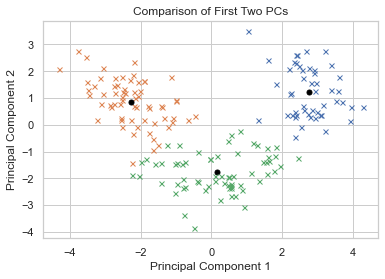

In [22]:
num_clusters = np.argmax(Q) + 2
kMeans = KMeans(n_clusters = num_clusters).fit(np.column_stack((rotated_data[:,0],
                                                                rotated_data[:,1])))
cId = kMeans.labels_ 
cCoords = kMeans.cluster_centers_ 

for i in range(num_clusters):
    plotIndex = np.argwhere(cId == int(i))
    plt.plot(rotated_data[plotIndex,0],rotated_data[plotIndex,1],'x',markersize=5)
    plt.plot(cCoords[int(i-1),0],cCoords[int(i-1),1],'o',markersize=5,color='black')  
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')    
    plt.title('Comparison of First Two PCs')

## Section 4.3 J.(i.)F.F.

Just (i guess) For Fun :)

This section maps the three chosen optimal number of clusters onto a 3d space with 3 PCs. This was done to visualize what k-means would look like in higher-dimensions with more variation in the data (explained by more PCs) included.

This section whould not be included as a part of this analysis, and was done for the sake of *visualization only*.

<IPython.core.display.Javascript object>


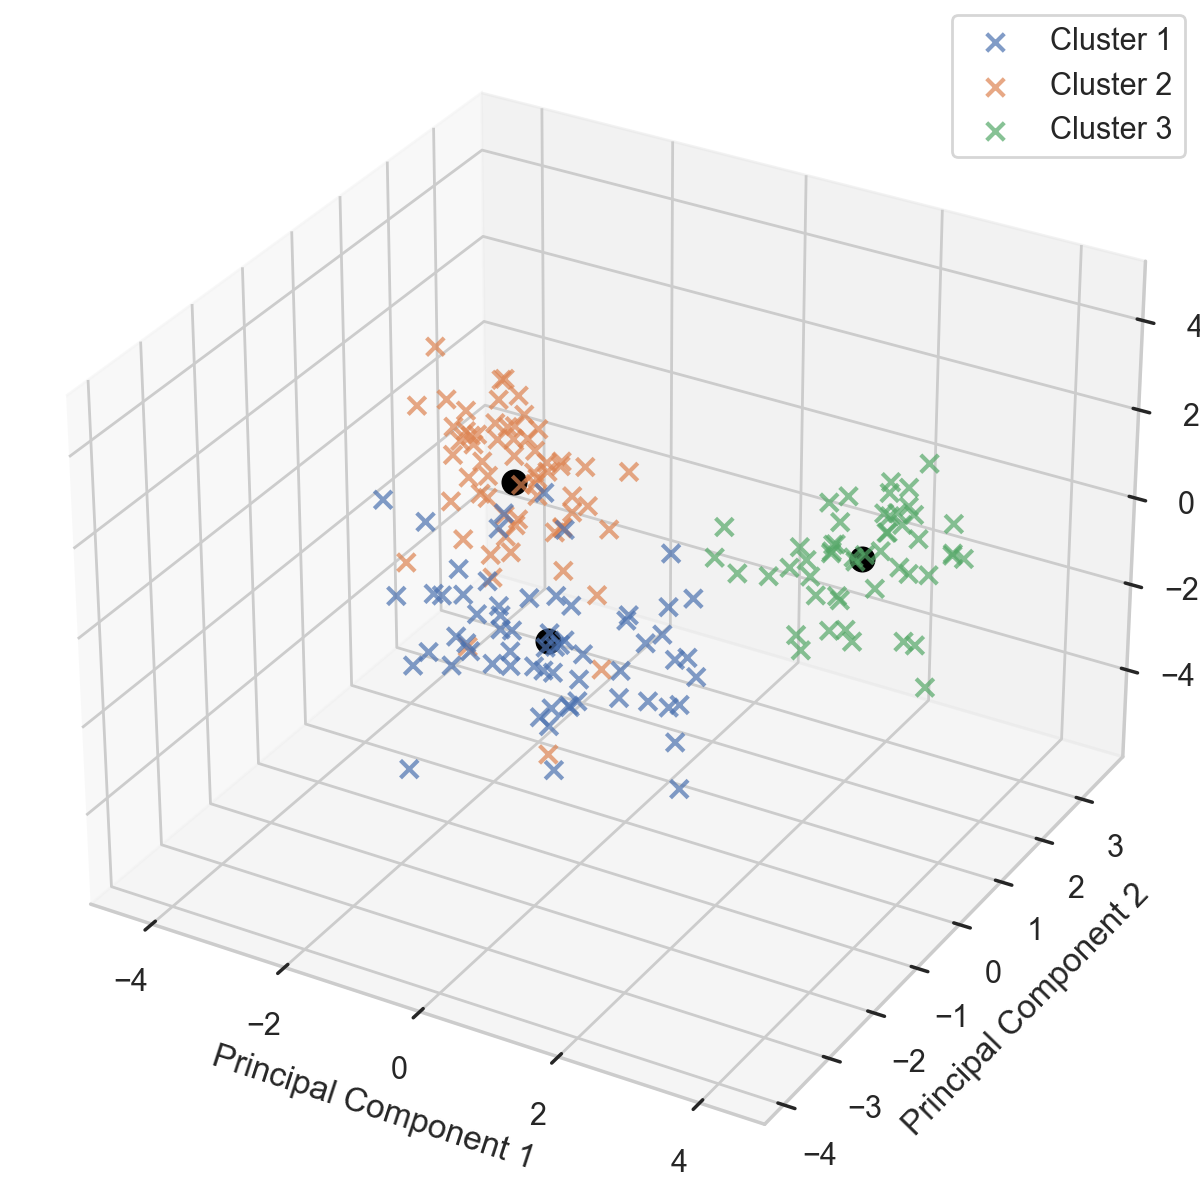

Text(0.5, 0, 'Principal Component 3')

In [23]:
%matplotlib notebook

num_clusters = np.argmax(Q) + 2
kMeans = KMeans(n_clusters = num_clusters).fit(np.column_stack((rotated_data[:,0],
                                                                rotated_data[:,1],
                                                                rotated_data[:,2]))) 
cId = kMeans.labels_ 
cCoords = kMeans.cluster_centers_ 

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Plot the color-coded data:
for i in range(num_clusters):
    
    plotIndex = np.argwhere(cId == int(i))
    
    sc = ax.scatter(rotated_data[plotIndex,0],
                    rotated_data[plotIndex,1],
                    rotated_data[plotIndex,2],
                    label=f'Cluster {i+1}',
                    s=40, marker='x', alpha=0.7)
    
    sc = ax.scatter(cCoords[int(i-1),0],
                    cCoords[int(i-1),1],
                    cCoords[int(i-1),2],
                    color='black', s=70)
    
ax.legend(loc='best')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

In [24]:
%matplotlib inline

## Section 4.4 Results & Discussion

From the above, we find that by implementing k-means on a PCA reduced `wines.csv`, with a sum of silhouette scores of `99`, and an optimal number of clusters of `3` (Sections 4.0 & 4.1), we obtain the visualization shown in Section 4.2.

This however, could *potentially* not be accurate given a brief viewing of the dataset: shown in Section 4.1, we can see isses with the dataset being potentially anisotropic, (almost parabolic in distributional shape), unequal variance (again, parabolic in distributional shape), therefore leading to the issue of being non-spherical. Potential outliers are also included in the analysis, such as the point around (2.6, 3.6) in the graph of Section 4.2.

However, this could also mean that using the first *two* PCs, explaining 45.40634% of the variation in the data (Section 1.6), `3` clusters *do* exist, allowing for further analysis through unsupervised classification.

# Question 5

Building on one of the dimensionality reduction methods above that yielded a 2D solution (1-3, your choice), use dBScan to produce a plot that represents each wine as a dot in a 2D space in the color of its cluster. Make sure to suitably pick the radius of the perimeter (“epsilon”) and the minimal number of points within the perimeter to form a cluster (“minPoints”) and comment on your choice of these two hyperparameters.

## Section 5.0 `DBSCAN` Initialization & Hyperparameter Tuning

For this Section, we realized the importance of using a distance-preserving method of dimensionality reduction, given DBSCAN's dependance on *density* metrics to create clusters. This is why I chose PCA as the form of dimensionality reduction to be used, as opposed to t-SNE, which only preserves *local* similarities. I did not choose MDS nor t-SNE due to the lack of open interpretability of factors (loadings).

We initialize an object of the `DBSCAN` class from `sklearn.cluster`. We create variables for iterating through: the `epsilon` variable containing all potential radii for considering a potential cluster extension, and `min_samples` containing the potential minimum number of samples to be tested.

Then, we created two dicts, `DBSCAN_labels` and `DBSCAN_dict` to store the `label` output of the fit `DBSCAN` model and the fit `DBSCAN` model itself.

This was done to create reusability of code at a later date: for easy access of both the model and the label associated.

Through hyperparameter tuning, found that $0.3 \geq \epsilon$ or the algorithm will produce less than two clusters, throwing a `ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)` for the `sklearn.silhouette_score` or `sklearn.silhouette_samples` packages. This is the reason for the tested `epsilon`s and `min_samples` to range from the numbers in the array listed.

In [15]:
epsilon = np.linspace(0.3, 1, 1000)
min_samples = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

x = np.column_stack((rotated_data[:,0],rotated_data[:,1]))

DBSCAN_labels = {}
DBSCAN_dict = {}

for eps in epsilon:
    for samples in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=samples).fit(x)
        labels = dbscan.labels_
        
        DBSCAN_dict[f'eps_{eps}_samples_{samples}'] = dbscan
        DBSCAN_labels[f'eps_{eps}_samples_{samples}'] = labels

## Section 5.1 Model Parameter Selection & Output

We instantiate an array, `silo_arr` to store all silhouette sums of each individual model created. We iterate through the `key`s and `value`s of `DBSCAN_labels`, using `re` to obtain the associated `epsilon` and `min_samples` parameters. We then determine the sum of silhouette scores for each model, and append this score to `silo_arr`. Finally, we print the silhouette scores, epsilon & min samples parameters.

This was done to obtain an array of silhouette scores, and provide a visual inspection (print output) of sum of silhouette scores.

In [ ]:
silo_arr = []
for key, value in DBSCAN_labels.items():
    eps = float(re.search('(?<=eps_)((\d+.\d+)|(\d+))(?=_samples)', key)[0])
    samples = int(re.search('(?<=_samples_)\d+', key)[0])
    
    sil = metrics.silhouette_samples(x, value)
    sum_sil = sum(sil)
    
    silo_arr.append([sum_sil, eps, samples])

    print(f'Silhouette: {sum_sil} for model with epsilon: {eps} & min samples: {samples}')

## Section 5.2 Maximum Silhouette Determination

Below, we find the index of the maximum value in `silo_arr[:,0]`, or the column associated with the silhouette score. Using this index, we extract three variables from `silo_arr`:

   * `max_silo`: maximum sum of silhouette score

   * `max_eps`: epsilon associated with `max_silo`

   * `max_samples`: number of min samples associated with `max_silo`.

We then print these three variables

This is done to determine the parameters to be passed to the next block of code, which determines the number of clusters to be used.

In [17]:
silo_arr = np.array(silo_arr)
max_idx = np.argmax(silo_arr[:,0])

max_silo = silo_arr[max_idx,0]
max_eps = silo_arr[max_idx,1]
max_samples = silo_arr[max_idx,2]

print(f'Maximum Silhouette Model: Sum of Silhouette = {max_silo:.4f}, Epsilon = {max_eps:.4f}, Minimum Samples = {max_samples}')

Maximum Silhouette Model: Sum of Silhouette = 83.6580, Epsilon = 0.7246, Minimum Samples = 10.0


## Section 5.3 Number of Cluster Determination

Below, we determine the number of clusters to be implemented using the determined `episilon` & `samples` from above (`max_silo` & `max_eps`). We call the `DBSCAN_dict` & `DBSCAN_labels` to retrieve the `labels` array of output labels and `dbscan` model associated with the maximum silhouette model.

Next, we find the number of clusters present in the model with maximum sum of silhouette scores, by taking the length of the array of unique values in `labels`, subtracting 1 if a negative class, `-1`, exists in the `labels` array.[<sup>[7]</sup>](#fn7)

We then print the number of non-negative classes (clusters) present.

This was done to show the number of clusters present, minus the number of outliers not identified as a cluster by the DBSCAN algorithm.

In [18]:
eps = max_eps
samples = max_samples

labels = DBSCAN_labels[f'eps_{eps}_samples_{samples:.0f}']
dbscan = DBSCAN_dict[f'eps_{eps}_samples_{samples:.0f}']

n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)## Code derived from source above [7]

print(n_clusters)

3


## Section 5.4 Plotting of PCA Dimensionality Reduction & DBSCAN Clustering

Below we plot PC1 & PC2 against one another, and the associated cluster color for each datapoint by cycling through `range(-1, n_clusters + 1)` to show negative, outlier cases (with `label = -1`) and positive cases (integers `1, 2, 3,... n` classes) in the 2d plane spanned by both PCs.

We did this to plot a visualization of the clustering on the `rotated_data` of the dataset provided. We decided to include all label classes, including outliers in the plot (indicated by `blue`), and the 3 obtained clusters (indicated by `orange`, `green`, and `red`).

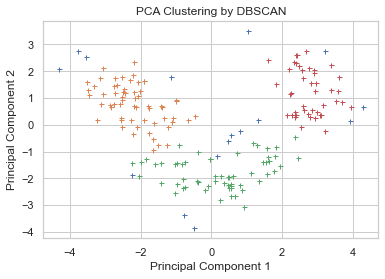

In [19]:
for i in range(-1, n_clusters + 1):
    labelIndex = np.argwhere(labels == i)
    plt.plot(rotated_data[labelIndex,0],rotated_data[labelIndex,1],'+',markersize=5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')    
    plt.title('PCA Clustering by DBSCAN')

## Section 5.5 Results & Discussion

From the above, we find that the optimal DBSCAN model used to cluster PCA creates a sum of silhouette score of 83.6580 using an `epsilon` of 0.72462 and `min_samples` of 10. Furthermore, we determine that, using the aforementioned hyperparameters, we obtain 3 clusters (as well as an outlier class).

No forward disadvantages of DBSCAN were determined as being applicable here: the dataset is not sparse and, while sensitive to the aforementioned hyperparameters, we tuned those same hyperparameters for maximal sum of silhouette score.[<sup>[1]</sup>](#fn1)

Conversely, given the abnormal distribution of this dataset as well as the potential for outliers & noise (from viewing the plot of both PCs), we see DBSCAN as a potential better candidate for clustering this dataset than k-means (Section 4).

We interpret this as potentially meaning that using the first *two* PCs, explaining 45.40634% of the variation in the data (Section 1.6), 3 clusters exist, allowing for further analysis through unsupervised classification.

# Extra Credit A

Given your answers to all of these questions taken together, how many different kinds of wine do you think there are and how do they differ?

## Section A.0

Looking at the `rotated_data` of the corresponding PCA analyses (inclusive of the two clustering methods k-means and DBSCAN), as well as the t-SNE & MDS plots (through eyeballing), each method produced the following (perhaps tentative) results:

* PCA - when viewing PC1 & PC2 (shown below), we see that for
    * PC1: loadings points positively towards `Malic_Acid`, `Ash_Alkalinity`, and `Stilbenes` but very negatively towards `Totel_Phenols`, `Flavonoids`, `Proanthocyanins`, `Hue`, `OD280`, and `Proline`.
    
    * PC2: positively towards `Alcohol`, `Malic_Acid`, `Ash`, `Magnesium`, strongly towards `Color_Intensity`, and `Proline` but negatively towards `Hue` and `OD280`.
    
    * Through eyeballing, we see that three potential clusters are apparent.
    
    
* t-SNE - When plotting the t-SNE plot (shown in Section 2), by eyeballing (due to not having done analysis through k-means or DBSCAN due to them being distance-based metrics), three potential clusters are apparent.


* MDS - When plotting the MDS plot (shown in Section 3), by eyeballing (due to not having done analysis through k-means or DBSCAN due to them being distance-based metrics), three potential clusters are apparent.


* k-means (w/ PCA) - using k-means on the PCA of the `wines.csv` data, we obtained the highest silhouette score using 3 clusters (Section 4).


* DBSCAN (w/ PCA) - using DBSCAN on the PCA of the `wines.csv` data, we obtained the highest silhouette score using 3 clusters (Section 5).

Through all of these analyses, the first three were all eyeballed (with no clustering methods being applied). For the clustering methods used (k-means & DBSCAN), there is potential for doubting the k-means method of analysis (as discussed in Section 4.4). 

However, results for both clustering methods seemed to point conclusively toward the existance of 3 clusters among the dataset we analyzed.

All else held constant, compounded with the minimal (but still present) benefit of eyeballing all three PCA, t-SNE, & MDS & other formal methods of classification k-means & DBSCAN, we can determine a total of 3 clusters, 3 "kinds of wine" as referencing this dataset.

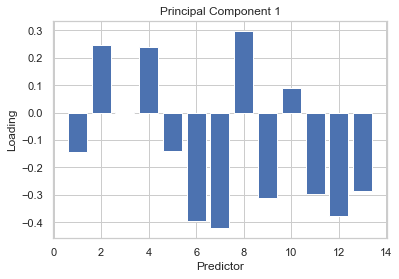

Loadings 1: Alcohol
Loadings 2: Malic_Acid
Loadings 3: Ash
Loadings 4: Ash_Alkalinity
Loadings 5: Magnesium
Loadings 6: Total_Phenols
Loadings 7: Flavonoids
Loadings 8: Stilbenes
Loadings 9: Proanthocyanins
Loadings 10: Color_Intensity
Loadings 11: Hue
Loadings 12: OD280
Loadings 13: Proline


In [549]:
num_col = len(df_zscore.columns)
x = np.linspace(1,num_col, num_col)

plt.bar(x,loadings[0,:])
plt.xlabel('Predictor')
plt.ylabel('Loading')
plt.title('Principal Component 1')
plt.show()

for index in range(len(df_zscore.columns)):
    print(f'Loadings {index+1}: {df_zscore.columns[index]}')

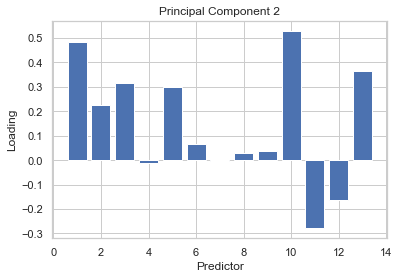

Loadings 1: Alcohol
Loadings 2: Malic_Acid
Loadings 3: Ash
Loadings 4: Ash_Alkalinity
Loadings 5: Magnesium
Loadings 6: Total_Phenols
Loadings 7: Flavonoids
Loadings 8: Stilbenes
Loadings 9: Proanthocyanins
Loadings 10: Color_Intensity
Loadings 11: Hue
Loadings 12: OD280
Loadings 13: Proline


In [551]:
num_col = len(df_zscore.columns)
x = np.linspace(1,num_col, num_col)

plt.bar(x,loadings[1,:])
plt.xlabel('Predictor')
plt.ylabel('Loading')
plt.title('Principal Component 2')
plt.show()

for index in range(len(df_zscore.columns)):
    print(f'Loadings {index+1}: {df_zscore.columns[index]}')

# Extra Credit B

Is there anything of interest you learned about wines from exploring this dataset with unsupervised machine learning method that is worth noting and not already covered in the questions above?

## Section B.0.1

Shown below in the first 2 PCs clustered using k-means & DBSCAN, we can see the presence of 3 distinct (optimal through calculation) clusters. However, upon interpreting the PCs (as we did in Section 1.6), we can see that PC1 & PC2 correspond to smell & taste respectively. 

From both clustering algorithms we can see that, given the initial parabolic-like distribution of data on the y-axis from the x-axis:

   * The first cluster (left-most) is low in PC1 & high in PC2
   * The second cluster (middle) is comparitively medium in PC1 but low in PC2
   * The third cluster (right most) is high in PC1 & high in PC2.
   
Interpreting the results, addending the notion of PC1 interpreted as smell & PC2 interpreted as taste (Section 1.6), we can see distinct clusters of wine attributable to around 3 different magnitudes of smell (low, medium, high), but only two kinds of taste (high, low).

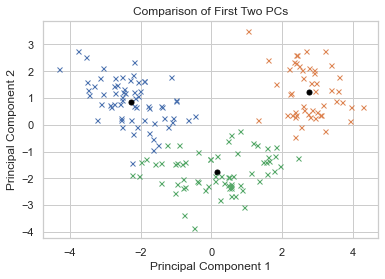

In [21]:
num_clusters = np.argmax(Q) + 2
kMeans = KMeans(n_clusters = num_clusters).fit(np.column_stack((rotated_data[:,0],
                                                                rotated_data[:,1])))
cId = kMeans.labels_
cCoords = kMeans.cluster_centers_

for i in range(num_clusters):
    plotIndex = np.argwhere(cId == int(i))
    plt.plot(rotated_data[plotIndex,0],rotated_data[plotIndex,1],'x',markersize=5)
    plt.plot(cCoords[int(i-1),0],cCoords[int(i-1),1],'o',markersize=5,color='black') 
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Comparison of First Two PCs')

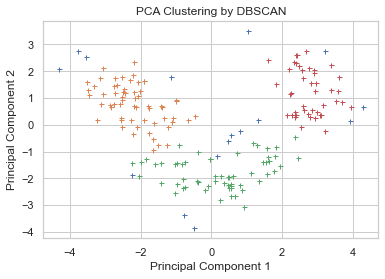

In [20]:
for i in range(-1, n_clusters + 1):
    labelIndex = np.argwhere(labels == i)
    plt.plot(rotated_data[labelIndex,0],rotated_data[labelIndex,1],'+',markersize=5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')    
    plt.title('PCA Clustering by DBSCAN')

# Sources Cited

[1] <span id='fn1'> https://towardsdatascience.com/k-means-vs-dbscan-clustering-49f8e627de27 </span>

[2] <span id='fn4'> https://statisticsbyjim.com/regression/interpret-f-test-overall-significance-regression/ </span>

[3] <span id='fn5'> https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html </span>

[4] <span id='fn6'> https://stats.stackexchange.com/questions/399868/why-does-larger-perplexity-tend-to-produce-clearer-clusters-in-t-sne#comment748790_399868 </span>

[5] <span id='fn7'> https://elutins.medium.com/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818 </span>

# Depreciated Code

Below is depreciated code not used in the final analysis, either through fallout from newer analysis or incorrectness of implementation.

## Section 1.1 Scree plot

Attempt to create a heuristic for eyeball method for determining number of PCs using the 2nd derivative and histogram of maximum change.

In [21]:
def eyeball(array): ## Array of eigenvalues && work in progress
    first = []
    second = []

    for entry, i in zip(array, range(len(array))):
        if i < len(array)-1:
            first.append(entry - array[i+1])

    for entry, i in zip(first, range(len(first))):
        if i < len(first)-1:
            second.append(entry - first[i+1])
            
    num = 0
    for entry, i in zip(second, range(len(second))):
        if i < len(second)-1:
            if np.absolute(entry) < np.absolute(second[i+1]):
                num += 1
    
    return num